In [19]:
from sklearn.manifold import TSNE
from abbasilab_v1dd import ARTIFACT_DIR
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pickle
import ast
from sklearn.mixture import GaussianMixture
import seaborn as sns
from matplotlib import cm

In [7]:
cell_info = pd.read_csv(ARTIFACT_DIR / "all_metrics_240503.csv")

/tmp/ipykernel_3133429/1227877109.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_info = pd.read_csv(ARTIFACT_DIR / "all_metrics_240503.csv")


In [4]:
res3 = ['frac_res_to_on', 'frac_res_to_off', 'frac_resp_full', 'frac_resp_windowed', 'frac_res_to_ns118', 'frac_res_to_ns12', 'frac_resp_natural_movie']
stim_names = ['LSN-ON', 'LSN-OFF', 'Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

features = cell_info[res3]
features.rename(columns = {
       'frac_res_to_on': "LSN-ON",
       'frac_res_to_off': "LSN-OFF",
       'frac_resp_full':'DGF',
       'frac_resp_windowed':'DGW',
       'frac_res_to_ns118':'NI',
       'frac_res_to_ns12':'NI12',
       'frac_resp_natural_movie':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_3130951/1287063842.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


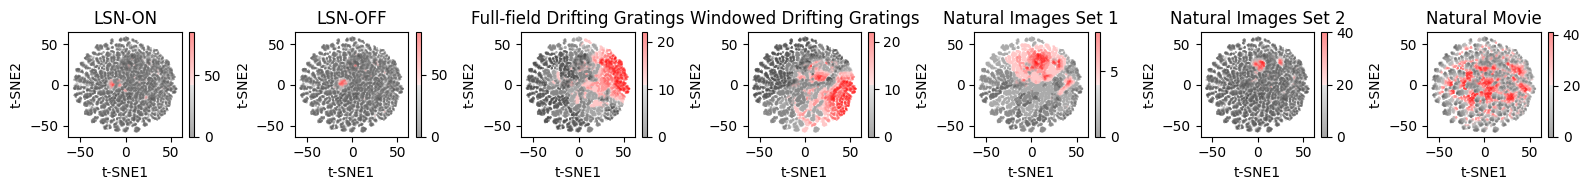

In [5]:
colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])  # Lighter dark gray start
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])  # Darker red end
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

def create_tsne_plot_2d(data, labels, stim_name, ax, perplexity=30, early_exaggeration=12.0, learning_rate=200, cmap='autumn'):
    """
    Creates a 2D t-SNE plot for the given high-dimensional data and labels with adjustable parameters,
    using a colorbar to the right of the plot to display the mapping of labels to colors.
    
    Parameters:
    - data: A numpy array of shape (n_samples, n_features) with the high-dimensional data.
    - labels: A numpy array of shape (n_samples,) with the labels for the data.
    - perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
    - early_exaggeration: Controls how tight natural clusters in the original space are in the embedded space.
    - learning_rate: The learning rate for t-SNE, usually in the range [10.0, 1000.0].
    """
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
    embedding = tsne.fit_transform(data)
    
    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    color_labels = np.array([label_to_color[label] for label in labels])

    sc = ax.scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        c=color_labels,
        cmap=cmap,
        alpha=0.5,
        s=0.001
    )

    plt.colorbar(sc, ax=ax)
    plt.tight_layout()
    ax.set_title(f'{stim_name}')
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')

plt.figure(figsize=(16, 2))
for j in range(7):
    X_subset = X
    X_subset_labels = features_stacked[:,j]
    ax = plt.subplot(1, 7, j+1)
    create_tsne_plot_2d(X_subset, X_subset_labels, stim_name=stim_names[j], ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

### GMM Clustering

In [8]:
res2 = ['frac_resp_full',
        'frac_resp_windowed',
        'frac_res_to_ns118',
        'frac_resp_natural_movie'
       ]
features = cell_info[res2]

features.rename(columns = {
       'frac_resp_full':'DGF',
       'frac_resp_windowed':'DGW',
       'frac_res_to_ns118':'NI',
       'frac_resp_natural_movie':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_3133429/130973804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


In [9]:
class CustomGMM(GaussianMixture): 
    def __init__(self, n_components=1, *, random_state=None, **kwargs): 
        super().__init__(n_components=n_components, random_state=random_state, **kwargs) 
        self.all_results_ = []
    def fit(self, X, y=None):
        super().fit(X, y) 
        result = {
                "n_components": self.n_components,
                "random_state": self.random_state,
                "log_likelihood": self.lower_bound_,
                "weights": self.weights_,
                "means": self.means_,
                "covariances": self.covariances_ 
                } 
        self.all_results_.append(result) 
        return self
    
def sum_by_class(class_labels, values):
    # Check if the arrays have the same length
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")

    # Create a dictionary to store class labels as keys and their summed values as values
    class_sums = {}

    # Loop through the arrays and sum the values for each class label
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value

    # Convert the dictionary values to a NumPy array
    summed_values = np.array(list(class_sums.values()))

    return summed_values

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [ ]:
# # saved_model = joblib.load(ARTIFACT_DIR / "clustering" / 'grid_search_1_50_clusters_100_initializations_231120.pkl')
# # saved_model = joblib.load(ARTIFACT_DIR / "clustering" / 'grid_search_1_50_clusters_100_initializations_240307.pkl')
# saved_model = joblib.load(ARTIFACT_DIR / "clustering" / 'grid_search_1_50_clusters_100_initializations_240315_no_lsn_ni12.pkl')


# print(f"Best Number of Clusters: {saved_model.best_params_['n_components']} with Score: {-saved_model.best_score_:.4f}")

Best Number of Clusters: 48 with Score: -267305.8217


In [10]:
tag = "240404"

In [11]:
# min_n_components = 29
# max_n_components = 30
# all_final_cluster_classes = []
# all_unique_classes_sorted = []
# all_summed_values = []
# all_clusters = []
# all_percent_neurons_in_mice = []
# all_mean_reliab_in_clusters_sorted = []
# all_new_class_idx_sorted = []

# for init in range(100):
#     param_grid = { 'n_components': list(range(min_n_components, max_n_components)), # Trying from 1 to 10 clusters 
#                 'random_state': [init] # Using random_state to simulate different initializations 
#                 }
#     custom_gmm = CustomGMM() 
#     model = GridSearchCV(custom_gmm, param_grid, cv=4, n_jobs=-1, verbose=4, scoring=gmm_bic_score)
#     model.fit(X) 
#     # Best parameters: 
#     print(f"Best Number of Clusters: {model.best_params_['n_components']} with Score: {-model.best_score_:.4f}")
    
#     clusters = model.best_estimator_.predict(X)
#     n_clusters = model.best_estimator_.means_.shape[0]
#     n_groups = 4

#     mean_reliab_in_clusters = np.zeros((n_clusters, n_groups))
#     groups_in_cluster = np.zeros((n_clusters, n_groups))

#     for cluster in range(n_clusters):
#         for g in range(n_groups):
#             cell_ind_in_cluster = np.where(clusters == cluster)[0]     
#             reliabilities_in_cluster = X[cell_ind_in_cluster, g]
#             mean_reliab_in_clusters[cluster, g] = np.nanmean(reliabilities_in_cluster)

#     cluster_means = model.best_estimator_.means_
#     cluster_means_array = np.mean(cluster_means, axis=1)
#     cluster_ind_sorted = np.argsort(cluster_means_array)
#     mean_reliab_in_clusters_sorted = mean_reliab_in_clusters[cluster_ind_sorted, :] 
#     all_mean_reliab_in_clusters_sorted.append(mean_reliab_in_clusters_sorted)
    
#     cluster_with_lowest_mean = cluster_ind_sorted[0]
#     # threshold for each column
#     threshold_for_each_column = mean_reliab_in_clusters[cluster_with_lowest_mean,:] + np.std(mean_reliab_in_clusters, axis = 0)
#     thresh = threshold_for_each_column

#     group_names = ["DGF","DGW","NI","NM"]
#     group_names_arr = np.asarray(group_names, dtype=object)
#     cluster_classes = []
#     cluster_assignments = mean_reliab_in_clusters_sorted > thresh
    
#     for cluster in range(n_clusters):
#         cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
#         cluster_classes.append(cluster_class)
#     unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
#     unique_classes_sorted = sorted(unique_classes, key=len)

#     classes = []
#     for x in cluster_classes:
#         index = unique_classes_sorted.index(x)
#         classes.append(index)
#     classes_arr = np.array(classes)
#     new_class_idx_sorted = np.argsort(classes_arr)
#     all_new_class_idx_sorted.append(new_class_idx_sorted)
    
#     final_cluster_classes = []
#     for cluster in range(n_clusters):
#         final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
#     final_classes = []
#     for cluster_class in final_cluster_classes:
#         index = unique_classes_sorted.index(cluster_class)
#         final_classes.append(index)

#     original_cluster_classes = []
#     cluster_assignments = mean_reliab_in_clusters > thresh
#     for cluster in range(n_clusters):
#         cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
#         original_cluster_classes.append(cluster_class)
    
#     all_final_cluster_classes.append(final_cluster_classes)
#     all_unique_classes_sorted.append(unique_classes_sorted)
   
#     percent_neurons_in_cluster = []
#     for cluster in new_class_idx_sorted:
#         cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
#         percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
#     summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
#     all_summed_values.append(summed_values)
    
#     # cell_info["cluster"] = clusters
#     all_clusters.append(clusters)

#     unique_mice = cell_info.mouse_id.unique()
#     percent_neurons_in_mouse = np.zeros((len(unique_mice)))

#     for i, mouse in enumerate(unique_mice):
#         mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

#         percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
#     all_percent_neurons_in_mice.append(percent_neurons_in_mouse)


# open_file = open(ARTIFACT_DIR / "clustering" / "all_final_cluster_classes_{tag}.pkl", "wb")
# pickle.dump(all_final_cluster_classes, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_unique_classes_sorted_{tag}.pkl", "wb")
# pickle.dump(all_unique_classes_sorted, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_summed_values_{tag}.pkl", "wb")
# pickle.dump(all_summed_values, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_clusters_{tag}.pkl", "wb")
# pickle.dump(all_clusters, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_percent_neurons_in_mice_{tag}.pkl", "wb")
# pickle.dump(all_percent_neurons_in_mice, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_mean_reliab_in_clusters_sorted_{tag}.pkl", "wb")
# pickle.dump(all_mean_reliab_in_clusters_sorted, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_new_class_idx_sorted_{tag}.pkl", "wb")
# pickle.dump(all_new_class_idx_sorted, open_file)
# open_file.close()

#### Load results for clusters and 100 iterations

In [12]:
open_file = open(ARTIFACT_DIR/ "clustering" /"all_final_cluster_classes_{tag}.pkl", "rb")
all_final_cluster_classes = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_unique_classes_sorted_{tag}.pkl", "rb")
all_unique_classes_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_summed_values_{tag}.pkl", "rb")
all_summed_values = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_clusters_{tag}.pkl", "rb")
all_clusters = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_percent_neurons_in_mice_{tag}.pkl", "rb")
all_percent_neurons_in_mice = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_mean_reliab_in_clusters_sorted_{tag}.pkl", "rb")
all_mean_reliab_in_clusters_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_new_class_idx_sorted_{tag}.pkl", "rb")
all_new_class_idx_sorted = pickle.load(open_file)
open_file.close()

In [13]:
all_final_cluster_classes = []
all_unique_classes_sorted = []
all_summed_values = []
all_percent_neurons_in_mice = []
all_new_class_idx_sorted = []

for init in range(100):
    
    clusters = all_clusters[init]
    n_clusters = 29
    n_groups = 4

    mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]

    # threshold2 = 0.75

    cluster_with_lowest_mean = 0 # it is already sorted
    threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
        np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])

    group_names = ["DGF","DGW","NI","NM"]
    group_names_arr = np.asarray(group_names, dtype=object)
    cluster_classes = []
    cluster_assignments = mean_reliab_in_clusters > threshold2
    
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        cluster_classes.append(cluster_class)
    unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
    unique_classes_sorted = sorted(unique_classes, key=len)

    classes = []
    for x in cluster_classes:
        index = unique_classes_sorted.index(x)
        classes.append(index)
    classes_arr = np.array(classes)
    new_class_idx_sorted = np.argsort(classes_arr)
    all_new_class_idx_sorted.append(new_class_idx_sorted)
    
    final_cluster_classes = []
    for cluster in range(n_clusters):
        final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)

    original_cluster_classes = []
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        original_cluster_classes.append(cluster_class)
    
    all_final_cluster_classes.append(final_cluster_classes)
    all_unique_classes_sorted.append(unique_classes_sorted)
   
    percent_neurons_in_cluster = []
    for cluster in new_class_idx_sorted:
        cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
        percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
    summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
    all_summed_values.append(summed_values)
    
    # cell_info["cluster"] = clusters
    # all_clusters.append(clusters)

    unique_mice = cell_info.mouse_id.unique()
    percent_neurons_in_mouse = np.zeros((len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

        percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
    all_percent_neurons_in_mice.append(percent_neurons_in_mouse)


In [14]:
classes_arr

array([ 0,  3,  0,  0,  0,  1,  1,  2,  1,  7,  5,  3,  6,  4,  9,  5,  3,
        4,  6,  6,  8,  9,  5,  4,  6,  8, 10,  8, 11])

In [15]:
all_final_cluster_classes[0]

[[],
 [],
 [],
 ['NM'],
 ['NM'],
 ['NM'],
 ['DGF'],
 ['DGW'],
 ['DGW'],
 ['DGW'],
 ['NI'],
 ['NI'],
 ['NI'],
 ['DGW', 'NI'],
 ['DGW', 'NM'],
 ['DGW', 'NM'],
 ['NI', 'NM'],
 ['NI', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'DGW'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGW', 'NI', 'NM'],
 ['DGF', 'NI', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

In [16]:
# thresholds = []

# for init in range(100):
#     mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]
#     cluster_with_lowest_mean = 0 # it is already sorted
#     threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
#         np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])
#     thresholds.append(threshold2)
    
# plt.figure(figsize=((4,3)))
# plt.hist(thresholds, 100)
# plt.title('Thresholds')
# plt.show()

### Include 0s in mean and std

In [17]:
ordered_clusters = [
    [],
    ['DGF'],
    ['DGW'],
    ['DGF', 'DGW'],
    ['NI'],
    ['DGF', 'NI'],
    ['DGW', 'NI'],
    ['DGF', 'DGW', 'NI'],
    ['NM'],
    ['DGF', 'NM'],
    ['DGW', 'NM'],
    ['DGF', 'DGW', 'NM'],
    ['NI', 'NM'],
    ['DGW', 'NI', 'NM'],
    ['DGF', 'NI', 'NM'],
    ['DGF', 'DGW', 'NI', 'NM']
]


In [20]:
def plot_mean_values_above_threshold_colored_order(data, values, ordered_clusters, threshold=0, plot=1, return_sorted=0): 
    # Flatten the data and get the union of lists of strings 
    flattened_data = [str(lst) for member in data for lst in member] 
    union_labels = list(set(flattened_data)) # Compute mean and standard error for each label in the union 
    means = [] 
    errors = [] 
    labels = [] 
    label_index = []
    for ilabel, label in enumerate(union_labels): 
        corresponding_values = [] 
        count = 0 # Count occurrences of the label 
        for i, member in enumerate(data): 
            for j, sublist in enumerate(member): 
                if str(sublist) == label: 
                    if isinstance(values[i][j], (list, np.ndarray)): # Check if iterable 
                        corresponding_values.extend(values[i][j].tolist()) 
                    else: # If it's a single float value 
                        corresponding_values.append(values[i][j]) 
                        count += 1
        if count < threshold: # Skip if the label doesn't meet the threshold 
            continue
        label_index.append(ilabel)
        
        
        corresponding_values_2 = corresponding_values + [0] * (100 - len(corresponding_values))

        # print(np.mean(corresponding_values) , np.std(corresponding_values) / np.sqrt(len(corresponding_values)), \
        #     np.mean(corresponding_values_2), np.std(corresponding_values_2) / np.sqrt(len(corresponding_values_2)) )
        mean = np.mean(corresponding_values_2) 
        std_error = np.std(corresponding_values_2) / np.sqrt(len(corresponding_values_2)) 
        means.append(mean) 
        errors.append(std_error) 
        labels.append(label) # Sort the results in descending order based on means
    sorted_indices = np.argsort(means)[::-1] 
    means = np.array(means)[sorted_indices].tolist() 
    errors = np.array(errors)[sorted_indices].tolist()
    labels = np.array(labels)[sorted_indices].tolist()
    new_labels = [ast.literal_eval(label) for label in labels]
    # indices = [new_labels.index(label) for label in ordered_clusters if label in ordered_clusters]
    # new_means = [means[i] for i in indices]
    # new_errs = [errors[i] for i in indices]
    # newer_labels = [str(ordered_clusters[i]) for i in range(len(ordered_clusters))]
    
    indices = [new_labels.index(label) if label in new_labels else -1 for label in ordered_clusters]
    new_means = [means[i] if i != -1 else 0 for i in indices]
    new_errs = [errors[i] if i != -1 else 0 for i in indices]
    newer_labels = [str(label) for label in ordered_clusters]
    
    n_colors = 16#len(labels)
    color_palette = sns.husl_palette(n_colors)
    
    if plot:
        fig = plt.figure(figsize=(10, 7)) 
        bars = plt.bar(newer_labels, new_means, yerr=new_errs, capsize=5, color=color_palette) 
        plt.xticks(rotation=45, ha="right", fontsize=10) 
        plt.yticks(fontsize=10) 
        plt.ylabel('Percent of neurons', fontsize=14) 
        plt.tight_layout() 
        # plt.show()
        plt.ylim([0, 40])
        # fig.savefig(f"clustering_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')
        
        
    if return_sorted:
        return sorted_indices, indices, label_index
        # return indices

In [21]:
all_unique_classes_sorted[0]

[[],
 ['NM'],
 ['DGF'],
 ['DGW'],
 ['NI'],
 ['DGW', 'NI'],
 ['DGW', 'NM'],
 ['NI', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'DGW'],
 ['DGF', 'DGW', 'NM'],
 ['DGW', 'NI', 'NM'],
 ['DGF', 'NI', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

In [22]:
all_summed_values[0]

array([13.31167729, 10.63598601,  1.89584725,  6.02256907,  9.77804439,
        3.56192912,  7.72147457,  6.21951081, 11.86177859,  5.36043735,
       11.54033344,  1.53365553,  3.91393419,  6.64282238])

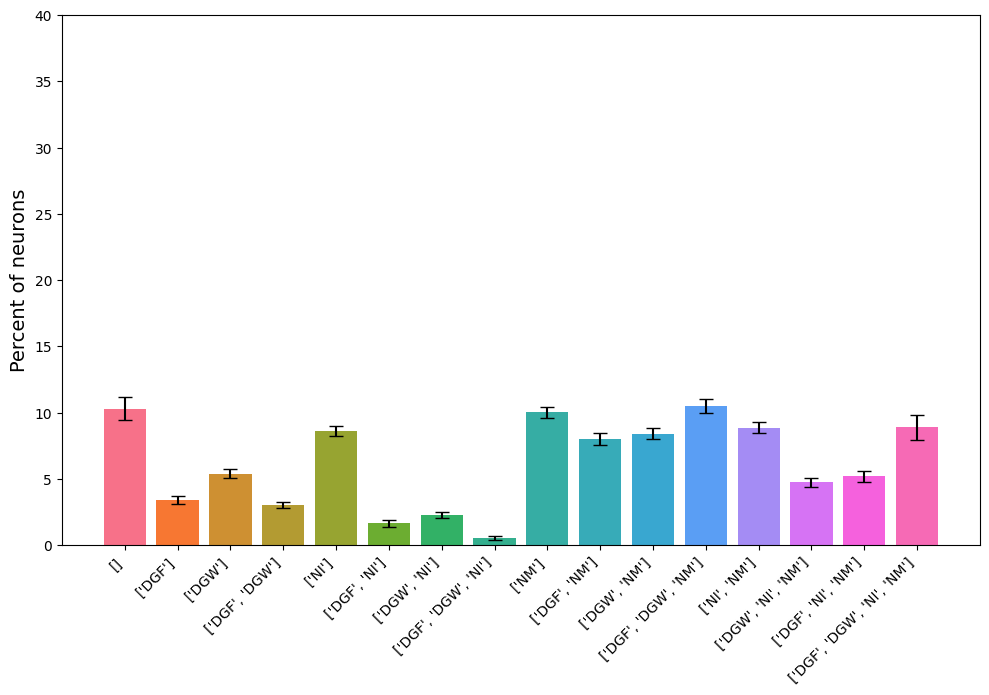

In [23]:
plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted, all_summed_values, \
    ordered_clusters, threshold=0)

#### Plot the clusters for 1 example iteration

In [24]:
from matplotlib.colors import LinearSegmentedColormap 
# Define the new colormap 
cmap_data = { 'red': [(0, 0, 0), (0.25, 1, 1), (0.4,1,1), (1, 0.9, 0.9)], 'green': [(0, 0, 0), (0.25, 1, 1), (0.4,0.45,0.45), (1, 0, 0)], 'blue': [(0, 1, 1), (0.25, 1, 1),(0.4,0.45,0.45), (1, 0, 0)] } 
dark_red_bwr = LinearSegmentedColormap('dark_red_bwr', cmap_data) 


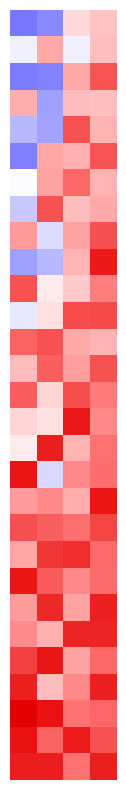

In [25]:
iter_num = 1
mean_reliab_in_clusters_sorted = all_mean_reliab_in_clusters_sorted[iter_num]
thresh = 0.05
plt.figure(figsize=(20,10))
plt.imshow(mean_reliab_in_clusters_sorted, cmap =dark_red_bwr)
plt.clim(vmin = -np.min(thresh),vmax = 1)
plt.axis("off")

plt.show()

In [26]:
mean_reliab_in_clusters_sorted

array([[0.07510784, 0.0900876 , 0.2573324 , 0.28207635],
       [0.19858588, 0.30822463, 0.19617945, 0.28483936],
       [0.08100793, 0.08760378, 0.30779416, 0.53689045],
       [0.30660338, 0.11679514, 0.28983583, 0.28604338],
       [0.14266238, 0.11918875, 0.55342301, 0.29697191],
       [0.08403894, 0.31148702, 0.30019014, 0.53418641],
       [0.21125085, 0.31592751, 0.43033168, 0.29510617],
       [0.15904117, 0.55005874, 0.28693262, 0.30807803],
       [0.32729417, 0.17814224, 0.3158658 , 0.56085378],
       [0.117335  , 0.14010317, 0.2979446 , 0.85295813],
       [0.55116118, 0.23503725, 0.27351304, 0.35835938],
       [0.19013969, 0.24940781, 0.57989966, 0.5900975 ],
       [0.46263194, 0.55401231, 0.30703217, 0.29511464],
       [0.2885227 , 0.48093532, 0.32174936, 0.54899368],
       [0.48888129, 0.25776869, 0.57727804, 0.36084372],
       [0.26171625, 0.24669436, 0.8674015 , 0.34410048],
       [0.23401186, 0.83880106, 0.29508377, 0.3793561 ],
       [0.87554124, 0.17467354,

In [27]:
cluster_assignments

array([[False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False,  True, False, False],
       [False, False, False,  True],
       [ True,  True, False, False],
       [False, False,  True,  True],
       [False, False,  True, False],
       [ True, False, False,  True],
       [False,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False,  True, False],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True],
 

In [28]:

cluster_assignments = mean_reliab_in_clusters_sorted > threshold2
group_names = ["DGF","DGW","NI","NM"]
group_names_arr = np.asarray(group_names, dtype=object)
    
for cluster in range(n_clusters):
    cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
    print(cluster_class)
    # cluster_classes.append(cluster_class)

[]
[]
['NM']
[]
['NI']
['NM']
['NI']
['DGW']
['NM']
['NM']
['DGF']
['NI', 'NM']
['DGF', 'DGW']
['DGW', 'NM']
['DGF', 'NI']
['NI']
['DGW', 'NM']
['DGF', 'NM']
['NM']
['DGF', 'DGW', 'NI', 'NM']
['DGW', 'NI', 'NM']
['DGF', 'DGW', 'NM']
['DGW', 'NM']
['NI', 'NM']
['DGF', 'DGW', 'NM']
['DGF', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']


#### Find the union of clusters across 100 iterations

In [29]:
def union_lists(data):
    result = [] 
    for member in data:
        for lst in member: 
            if lst not in result: 
                result.append(lst) 
    return result 

cluster_union = union_lists(all_unique_classes_sorted) 
print(f"There are {len(cluster_union)} unique clusters across 100 iterations.")

There are 16 unique clusters across 100 iterations.


#### Plot percent for each mouse and each cluster

In [30]:
flattened_data = [str(lst) for member in all_unique_classes_sorted for lst in member] 
union_classes = list(set(flattened_data)) 
len(union_classes)

16

In [31]:
unique_mice = cell_info.mouse_id.unique()
all_percent_neurons_in_cluster_class_mouse_80 = np.zeros((100,len(union_classes), len(unique_mice)))
union_classes_lst_of_lsts = [ast.literal_eval(item) for item in union_classes]


In [32]:
def create_output_array(a, b, c): 
    # Initialize the output array with zeros 
    output = np.zeros(len(a)) # Loop over the list 'a' 
    for i, element_a in enumerate(a): # Check if element_a is in b 
        if element_a in b: # If it is, find the corresponding index in b 
            idx = b.index(element_a) # Set the output value to the corresponding value in c 
            output[i] = c[idx] 
    return output

In [33]:
def sum_by_class(class_labels, values):
    # Check if the arrays have the same length
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")

    # Create a dictionary to store class labels as keys and their summed values as values
    class_sums = {}

    # Loop through the arrays and sum the values for each class label
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value

    # Convert the dictionary values to a NumPy array
    summed_values = np.array(list(class_sums.values()))

    return summed_values

In [34]:

for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_class_mouse = np.zeros((len(unique_classes_sorted), len(unique_mice)))
    mean_percent_neurons_in_cluster_mouse = np.zeros((len(new_class_idx_sorted), len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        for cluster in new_class_idx_sorted:
            mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

            cell_ind_in_cluster_mouse = np.where((clusters == cluster))[0]
            cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_mouse]
            cluster_mouse_cell_info = cluster_cell_info.loc[cluster_cell_info["mouse_id"] == mouse]

            mean_percent_neurons_in_cluster_mouse[cluster, i] = len(cluster_mouse_cell_info)*100/ len(mouse_cell_info)
        percent_neurons_in_cluster_class_mouse[:,i] = sum_by_class(final_classes, mean_percent_neurons_in_cluster_mouse[:, i].tolist())
        
        all_percent_neurons_in_cluster_class_mouse_80[iter_num,:,i] = create_output_array(union_classes_lst_of_lsts, \
            unique_classes_sorted, percent_neurons_in_cluster_class_mouse[:,i]) 

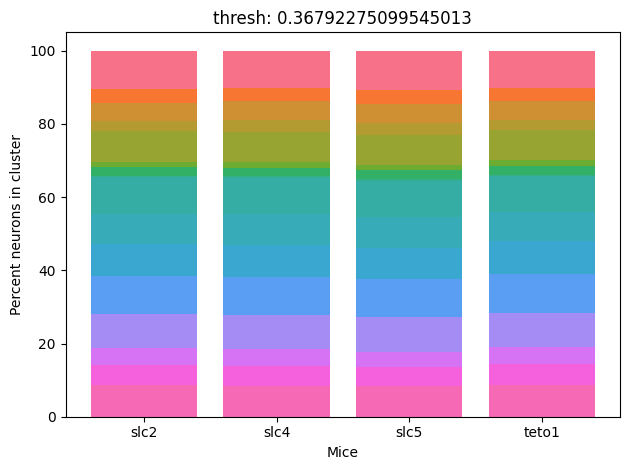

In [35]:

sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

percent_neurons_in_cluster_class_mouse = np.zeros((16,4))

for idx, val in enumerate(indices):
    if val != -1:
        percent_neurons_in_cluster_class_mouse[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_mouse_80[:, sorted_indices_1[val], :], axis=0)


n_colors = 16#all_percent_neurons_in_cluster_class_mouse_80.shape[1]
color_palette = sns.husl_palette(n_colors)

data = percent_neurons_in_cluster_class_mouse
num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8

# Reverse the order of the rows in the data array
data_flipped = np.flip(data, axis=0)
# data_flipped = data
color_palette_flipped = np.flip(color_palette, axis=0)
# Plot the shades vertically separated within one bar with specified colors
bottom = np.zeros(num_bars)
fig=plt.figure()
for i in range(num_shades):
    bar = plt.bar(x, data_flipped[i, :], width=bar_width, bottom=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Mice')
plt.ylabel('Percent neurons in cluster')
plt.title(f"thresh: {threshold2}")
plt.xticks(x, ["slc2", "slc4", "slc5", "teto1"])
plt.tight_layout()
# plt.show()
# fig.savefig(f"per_mouse_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')


### Plot percent for each depth

In [36]:
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
   [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

In [37]:
total_vol_plane_pairs = len(z_groups_low_to_high)
all_percent_neurons_in_cluster_class_volume_80 = np.zeros((100,len(union_classes),13))


for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_volume = np.zeros((len(new_class_idx_sorted), total_vol_plane_pairs))
    z_num = 0

    for z_group in z_groups_low_to_high:
            plane_volume_cell_info = cell_info.loc[cell_info["z"].isin(z_group)]
            for cluster in new_class_idx_sorted:
                cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
                cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_1_g0]
                cluster_volume_plane_cell_info = cluster_cell_info.loc[cluster_cell_info["z"].isin(z_group)]
                
                if len(plane_volume_cell_info) != 0:
                    percent_neurons_in_cluster_volume[cluster, z_num] = len(cluster_volume_plane_cell_info)*100/len(plane_volume_cell_info)
            if len(plane_volume_cell_info) != 0:
                z_num += 1
    percent_neurons_in_cluster_class_volume = np.zeros((len(unique_classes_sorted), total_vol_plane_pairs))

    for vol_plane_pair in range(total_vol_plane_pairs):

        percent_neurons_in_cluster_volume_list = percent_neurons_in_cluster_volume[:,vol_plane_pair].tolist()
        percent_neurons_in_cluster_class_volume[:,vol_plane_pair] = sum_by_class(final_classes, percent_neurons_in_cluster_volume_list)

        all_percent_neurons_in_cluster_class_volume_80[iter_num,:,vol_plane_pair] = \
            create_output_array(union_classes_lst_of_lsts, unique_classes_sorted,  \
                percent_neurons_in_cluster_class_volume[:,vol_plane_pair])

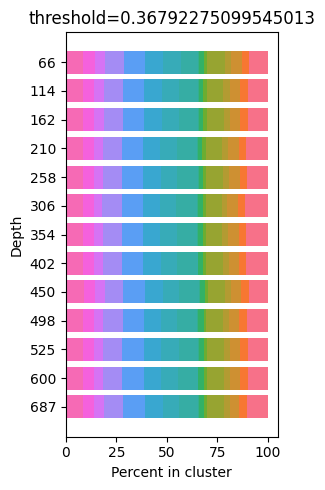

In [38]:
sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

all_percent_neurons_in_cluster_class_mouse_19_ordered = np.zeros((16,13))

for idx, val in enumerate(indices):
    if val != -1:
        all_percent_neurons_in_cluster_class_mouse_19_ordered[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_volume_80[:, sorted_indices_1[val], :], axis=0)
data = np.array(all_percent_neurons_in_cluster_class_mouse_19_ordered)

n_colors = 16#data.shape[0]
color_palette = sns.husl_palette(n_colors)
color_palette_flipped = np.flip(color_palette, axis=0)

num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8

# Reverse the order of the rows in the data array
data_flipped = np.flip(data, axis=0)
bottom = np.zeros(num_bars)
means = [np.mean(group) for group in z_groups_low_to_high]


data_flipped = data_flipped[:, ::-1]
means = means[::-1]

x = np.arange(13)

fig = plt.figure(figsize=(3,5))
for i in range(num_shades):
    plt.barh(x, data_flipped[i, :], left=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Percent in cluster')
plt.ylabel('Depth')
plt.yticks(ticks=x, labels=[f'{int(mean)}' for mean in means])
plt.title(f"threshold={threshold2}")
plt.tight_layout()
# fig.savefig(f"per_depth_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')


### Make TSNE maps

In [ ]:
res3 = ['frac_resp_full', 'frac_resp_windowed', 'frac_resp_natural_images', 'frac_resp_natural_movie']
stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Scenes', 'Natural Movie']
colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])  # Lighter dark gray start

# For red: start from light red and end with a darker red
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])  # Darker red end
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

features = cell_info[res3]
features.rename(columns = {
       'frac_resp_full':'DGF',
       'frac_resp_windowed':'DGW',
       'frac_resp_natural_images':'NI',
       'frac_resp_natural_movie':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

def create_tsne_plot_2d(data, labels, stim_name, ax, perplexity=30, early_exaggeration=12.0, learning_rate=200, cmap='autumn'):
    """
    Creates a 2D t-SNE plot for the given high-dimensional data and labels with adjustable parameters,
    using a colorbar to the right of the plot to display the mapping of labels to colors.
    
    Parameters:
    - data: A numpy array of shape (n_samples, n_features) with the high-dimensional data.
    - labels: A numpy array of shape (n_samples,) with the labels for the data.
    - perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
    - early_exaggeration: Controls how tight natural clusters in the original space are in the embedded space.
    - learning_rate: The learning rate for t-SNE, usually in the range [10.0, 1000.0].
    """
    
    # Initialize t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
    embedding = tsne.fit_transform(data)
    
    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    color_labels = np.array([label_to_color[label] for label in labels])

    sc = ax.scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        c=color_labels,
        cmap=cmap,
        alpha=0.5,
        s=0.1
    )

    plt.colorbar(sc, ax=ax)
    plt.tight_layout()
    ax.set_title(f'{stim_name}')
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')

In [ ]:
sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)


In [ ]:
clusters = all_clusters[iter_num]
final_cluster_classes = all_final_cluster_classes[iter_num]
unique_classes_sorted = all_unique_classes_sorted[iter_num]
new_class_idx_sorted = all_new_class_idx_sorted[iter_num]

final_classes = []
for cluster_class in final_cluster_classes:
    index = unique_classes_sorted.index(cluster_class)
    final_classes.append(index)

In [ ]:
final_classes

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 4,
 5,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15]

In [ ]:
new_class_idx_sorted

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 19, 13, 12, 14,  8, 10, 17, 11,
       18, 22, 15, 20, 16, 21, 23, 27, 26, 24, 25, 28])

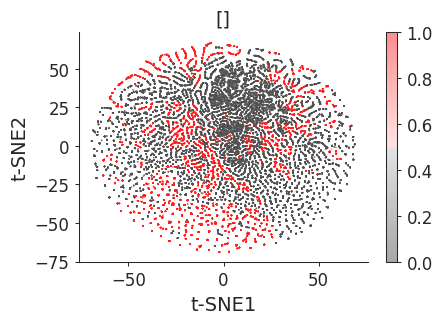

In [ ]:
for cluster in new_class_idx_sorted:
    
    indices = np.where(clusters=cluster)[0]
    
    cluster_indicator_array = np.zeros(len(cell_info), dtype=int)
    cluster_indicator_array[indices] = 1
    
    plt.figure(figsize=(16, 3))
    ax = plt.subplot(1, 4, 1)
    create_tsne_plot_2d(X, cluster_indicator_array, stim_name=f"{ordered_clusters[j]}", ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

In [ ]:
final_classes_array = np.array(final_classes)


# for o, cluster_combination in enumerate(ordered_clusters):
#         indices_equal_to = np.where(final_classes_array == o)[0]
#         cluster_indicator_array = np.zeros(len(cell_info), dtype=int)
#         cluster_indicator_array[indices_equal_to] = 1
    
#         plt.figure(figsize=(16, 3))
#         ax = plt.subplot(1, 4, 1)
#         create_tsne_plot_2d(X, cluster_indicator_array, stim_name=f"{ordered_clusters[j]}", ax=ax, perplexity=30, \
#                 early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

In [ ]:
final_classes_array

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  3,  4,
        5,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

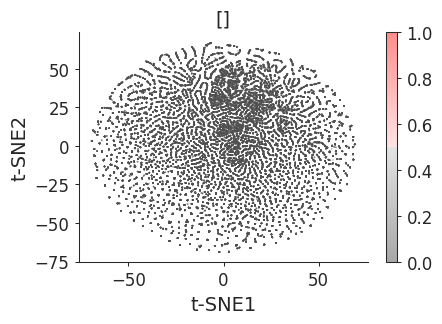

In [ ]:
o = 0
indices_equal_to = np.where(final_classes_array == o)[0]
cluster_indicator_array = np.zeros(len(cell_info), dtype=int)
cluster_indicator_array[indices_equal_to] = 1

plt.figure(figsize=(16, 3))
ax = plt.subplot(1, 4, 1)
create_tsne_plot_2d(X, cluster_indicator_array, stim_name=f"{ordered_clusters[o]}", ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)